# Code of "What gives your Airbnb a high rating?" project
Three business questions:  
1.Does the description of the listing affect the rating score?  
2.Does the description of the neighborhood affect the rating score?  
3.What are the objective factors affect the rating most?

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from collections import defaultdict
%matplotlib inline

# import dataset
df_listings = pd.read_csv('./listings.csv')

In [ ]:
# run this cell to take a look at the first 5 rows of the data
df_listings.head()

The whole project cares about what affects the **rating scores** of a Airbnb listing, so the first step is deleting the listings with missing values in **'review_scores_rating'**.

In [2]:
df_new = df_listings.dropna(subset = ['review_scores_rating'], axis = 0)

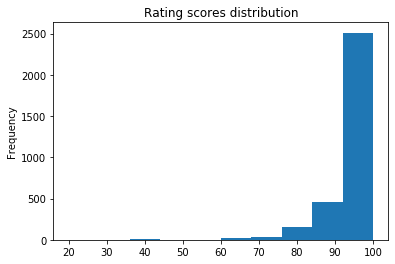

In [3]:
# run this cell to take a look at the ditribution of the rating scores of all the Airbnb listings in Seattle.
df_new.review_scores_rating.plot(kind = 'hist');
plt.title('Rating scores distribution');

### Comparing high rating score listings vs low rating score listings
I will first compare whether the Airbnb listings have higher rating scores are different from those with lower scores in some subjective factors -- such as how they describe the listing and the neighborhood (Question 1 & 2).   

To have two groups to compare, I extract those listings with higher scores (> 75% percentile) and lower scores(< 25% percentile).

## Solving Question 1
To simplify the question, I will only focus on the **adjectives** used in the descriptions.  

By looking through the descriptions in column **'description'** (a desciption of the Airbnb listing), I got some possible adjectives listing in the following variable **possible_adj**.

In [4]:
# We don't have NaN value in the 'description' variable
df_new.description.isnull().sum()

0

In [7]:
# separate data directly
y = df_new.review_scores_rating
df_high_score = df_new[y > np.percentile(y,75)]
df_low_score  = df_new[y < np.percentile(y,25)]

In [8]:
possible_adj = ['charming', 'private', 'elegant', 'cozy', 'comfortable', 
                'clean', 'wonderful', 'beautiful', 'modern', 'great',
                'functional', 'fresh', 'close', 'historic', 'quiet',
                'gorgeous', 'safe', 'convenient', 'lovely', 'vintage',
                'amazing', 'walkable', 'adorable', 'bright', 'light',
                'new', 'spacious', 'large', 'desirable', 'popular', 
                'special', 'fantastic', 'fabulous']

Here I use (modify) a code from Udacity class to count the number of above words showing in a column of a dataframe.

In [9]:
def count_word(df, col1, col2, look_for):
    '''
    Modified based on code from Udacity Data Scientist Nanodegree Lession 1. 
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col1]
    
    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx].lower():
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

The following function preprocess the dataframe you want to use and count the words (e.g. adjectives) of interest by calling the **count_word** function.

In [10]:
def get_count(df, col = 'description', search_for = possible_adj):
    '''
    Modified based on code from Udacity Data Scientist Nanodegree Lession 1.
    '''
    df_group = df[col].value_counts().reset_index()
    df_group.rename(columns={'index': 'key_words', col: 'count'}, inplace=True)
    df_key_word = count_word(df_group, 'key_words', 'count', search_for)
    
    df_key_word.set_index('key_words', inplace = True)
    return df_key_word

In [38]:
# plot out the adjective usage in high score listings and low score listings
adj_high      = get_count(df_high_score)
adj_low       = get_count(df_low_score)
prop_adj_high = adj_high/adj_high.sum()
prop_adj_low  = adj_low/adj_low.sum()

In [325]:
prop_adj_high.rename(columns={'count':'high_count'}, inplace = True)
prop_adj_low.rename(columns = {'count':'low_count'}, inplace = True)

In [326]:
prop_adj = pd.concat([prop_adj_high, prop_adj_low], axis=1, join='inner')

In [328]:
prop_adj

,high_count,low_count
key_words,,
close,0.087869,0.088479
private,0.079051,0.084978
great,0.072666,0.078931
large,0.072666,0.062062
light,0.068714,0.062381
quiet,0.061721,0.067473
new,0.059897,0.064609
beautiful,0.056552,0.049650
comfortable,0.048039,0.056970


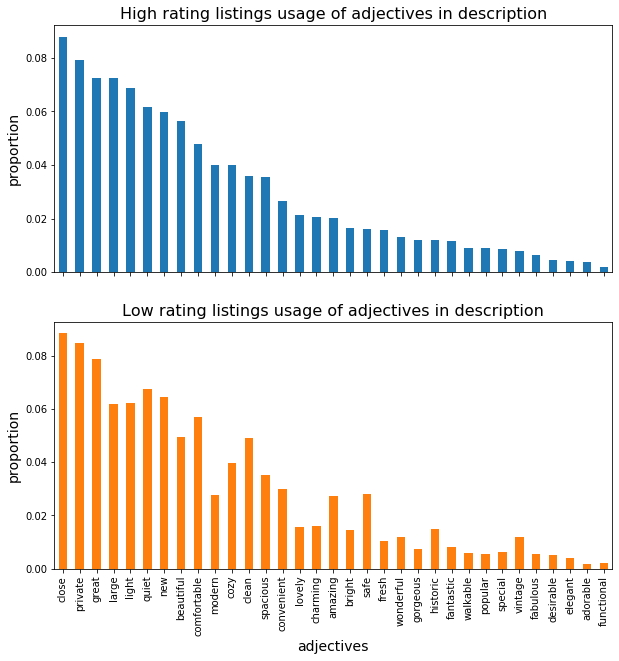

In [340]:
axes = prop_adj.plot.bar(legend = None, subplots=True, figsize = (10,10))
axes[0].set_xlabel('adjectives', fontsize = 14)
axes[0].set_ylabel('proportion', fontsize = 14)
axes[0].set_title('High rating listings usage of adjectives in description', fontsize = 16);
axes[1].set_xlabel('adjectives', fontsize = 14)
axes[1].set_ylabel('proportion', fontsize = 14)
axes[1].set_title('Low rating listings usage of adjectives in description', fontsize = 16);

In [343]:
fig = axes[0].get_figure()
fig.savefig('Description-high.png', dpi = 100)

In [342]:
plt.savefig('Description-high.png', dpi = 100)

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Low rating listings usage of adjectives in description')

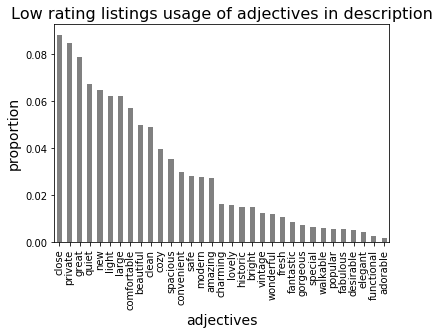

In [42]:
axes2 = prop_adj_low.plot.bar(legend = None, color = 'gray')
axes2.set_xlabel('adjectives', fontsize = 14)
axes2.set_ylabel('proportion', fontsize = 14)
axes2.set_title('Low rating listings usage of adjectives in description', fontsize = 16)

### Answer of Question 1
It seems there is no huge difference in the adjective usage in the descriptions between high rating score listings and low rating score listings -- at least the top three adjectives are the same between two groups.   

Other adjectives might have different order in the usage proportion, but not far from each other between these two groups. 

## Solving Question 2
Next, I will explore whether the **description of the neighborhood** (column **'neighborhood_overview'**) affects the rating score.  

Similar to question 1, I will compare the adjectives usage between high rating listings and low rating listings.

In [43]:
# There are NaN values in 'neighborhood_overview'
df_new.neighborhood_overview.isnull().sum()

738

In [44]:
# Delete rows with NaN in 'neighborhood_overview'
df_q2 = df_new.dropna(subset = ['neighborhood_overview'], axis = 0)

In [45]:
# separate data into high rating group and low rating group
y_q2 = df_q2.review_scores_rating
df2_high_score = df_q2[y_q2 > np.percentile(y_q2,75)]
df2_low_score  = df_q2[y_q2 < np.percentile(y_q2,25)]

In [46]:
# use get_count funtion to sort out the adjective usage
adj_high_neighbor      = get_count(df2_high_score, col = 'neighborhood_overview')
adj_low_neighbor       = get_count(df2_low_score, col = 'neighborhood_overview')
prop_adj_high_neighbor = adj_high_neighbor/adj_high_neighbor.sum()
prop_adj_low_neighbor  = adj_low_neighbor/adj_low_neighbor.sum()

Text(0.5, 1.0, 'Low rating listings usage of adjectives in neighborhood overview')

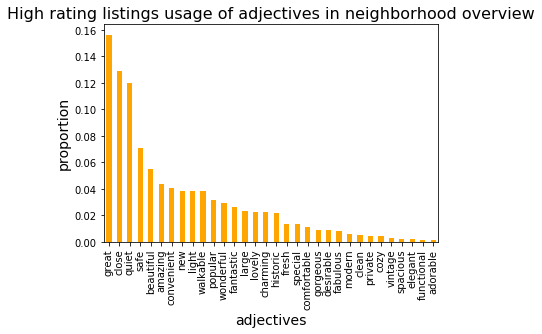

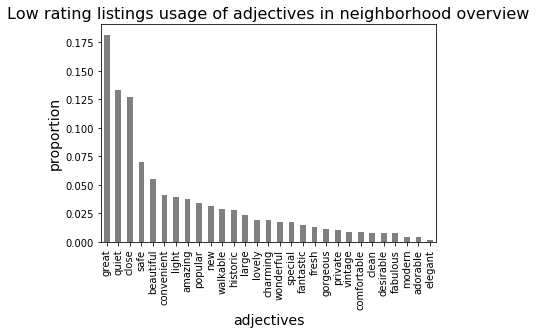

In [47]:
axes3 = prop_adj_high_neighbor.plot(kind = 'bar', legend = None, color = 'orange')
axes3.set_xlabel('adjectives', fontsize = 14)
axes3.set_ylabel('proportion', fontsize = 14)
axes3.set_title('High rating listings usage of adjectives in neighborhood overview', fontsize = 16)
axes4 = prop_adj_low_neighbor.plot(kind = 'bar', legend = None, color = 'grey')
axes4.set_xlabel('adjectives', fontsize = 14)
axes4.set_ylabel('proportion', fontsize = 14)
axes4.set_title('Low rating listings usage of adjectives in neighborhood overview', fontsize = 16)

Again, it seems the adjectives used in neighborhood overview between these two groups are not quite different from each other. And the top three adjectives are the same in the description of listings.  

Another factor of the description of neighborhood is nouns related to the entertainment and daily life, such as "shopping" and "coffee". By looking through the column **'neighborhood_overview'** I extract some daily life related noun in the variable **possible_noun**.  

I will plot out the noun usage between high rating score listings and low rating score listings.

In [48]:
possible_noun = ['restaurants', 'food', 'bars', 'coffee', 'cafes', 'shopping', 'music', 'mall', 'park', 'grocery', 'moive']

In [49]:
# use get_count funtion to sort out the noun usage
n_high_neighbor      = get_count(df_high_score, col = 'neighborhood_overview', search_for = possible_noun)
n_low_neighbor       = get_count(df_low_score, col = 'neighborhood_overview', search_for = possible_noun)
prop_n_high_neighbor = n_high_neighbor/n_high_neighbor.sum()
prop_n_low_neighbor  = n_low_neighbor/n_low_neighbor.sum()

Text(0.5, 1.0, 'Low rating listings usage of nouns in neighborhood overview')

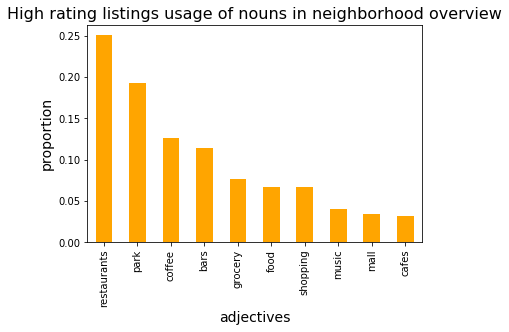

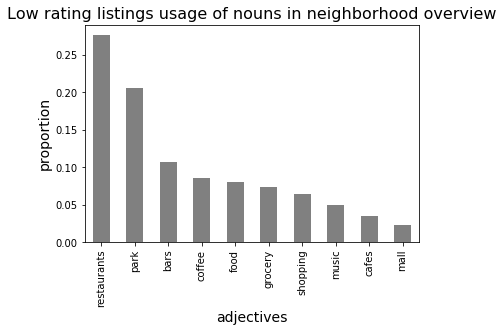

In [50]:
axes5 = prop_n_high_neighbor.plot(kind = 'bar', legend = None, color = 'orange')
axes5.set_xlabel('adjectives', fontsize = 14)
axes5.set_ylabel('proportion', fontsize = 14)
axes5.set_title('High rating listings usage of nouns in neighborhood overview', fontsize = 16)
axes6 = prop_n_low_neighbor.plot(kind = 'bar', legend = None, color = 'grey')
axes6.set_xlabel('adjectives', fontsize = 14)
axes6.set_ylabel('proportion', fontsize = 14)
axes6.set_title('Low rating listings usage of nouns in neighborhood overview', fontsize = 16)

It seems subjective factors did not affect the review score rating. The next step is to explore the objective factors.

## Solving Question 3

All the objective factors of interests include: 

**Quantitive variables:**  
1) 'accommodates'  
2) 'bathrooms'  
3) 'bedrooms'  
4) **'price_per_person'**: a new column I will create by dividing 'price' by 'accommodates' for each row  
5) 'security_deposit'  
6) 'cleaning_fee'  

**Categorical variables:**  
1) 'host_response_time': within an hour, within a few hours, within a day, a few days or more  
2) 'host_is_superhost': whether the host is a superhost or not, boolean variable  
3) 'host_has_profile_pic': whether the host provides a profile picture or not, boolean variable  
4) 'host_identity_verified': whether the host's identity is verified or not  
5) 'is_location_exact': whether the location provided is accurate or not  
6) 'room_type': entire home/apt, private room, shared room  
7) 'bed_type': real bed, futon, pull_out sofa, airbed, couch  
8) 'cancellation_policy': strict, moderate, flexible  
9) 'instant_bookable': boolean  
10) 'require_guest_profile_picture': boolean  
11) 'require_guest_phone_verification': boolean  

**Special varibales:** whether the row is null or not is the information we care about.  
1) 'transit': whether transportation method is provided  
2) 'host_about': whether the host provides self introduction  

In [ ]:
# use this cell to take a look at what variables have NaN values
df_new.isnull().sum().sort_values(ascending=False)

### Dealing with NaN

In [111]:
# for 'bathrooms' and we will replace the NaN by 1 (it is reasonable to assume that each Airbnb listing has at least 1 bathroom)
df_new['bathrooms'].fillna(1, inplace = True);

In [53]:
# for 'bedrooms', assumming that 1 bedroom can have 2 accommodates, I will replace the NaN in 'bedrooms' by (accommodates/2) for a given row
df_new['bedrooms'].fillna(df_new.accommodates/2, inplace = True)

/Users/yeli/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [54]:
# for 'security_deposit' and 'cleaning_fee', replace NaN by $0, then clean the data format to make them into float
df_new.fillna(value = {'security_deposit': '$0', 'cleaning_fee': '$0'}, inplace=True)

df_new.security_deposit = df_new.security_deposit.str.lstrip('$');
df_new.cleaning_fee = df_new.cleaning_fee.str.lstrip('$');
df_new.security_deposit = df_new.security_deposit.str.replace(',', '').astype(float)
df_new.cleaning_fee     = df_new.cleaning_fee.str.replace(',', '').astype(float)

/Users/yeli/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [76]:
# for 'price', first make it into float, then create a  to price per person
df_new.price = df_new.price.str.lstrip('$');
df_new.price = df_new.price.str.replace(',', '').astype(float)

In [80]:
df_new['price_per_person'] = df_new.price/df_new.accommodates

In [58]:
# for 'transit' and 'host_about', use NaN information to recode them into 1 = provided (not NaN) and 0 = not provided (is NaN)
df_new.transit    = df_new.transit.notnull().astype(int)
df_new.host_about = df_new.host_about.notnull().astype(int)

In [59]:
# for 'host_response_time', I will delete rows with NaN
df_new = df_new.dropna(subset = ['host_response_time'], axis = 0)

### Convert categorical variables to dummy variables, recode boolean variables to '1 vs 0'

In [63]:
# convert boolean variables (t = true, f = false) to 1 vs 0 coding (1 = true, 0 = false)
bool_process_col = ['host_is_superhost', 'host_has_profile_pic', 
                    'host_identity_verified', 'is_location_exact',
                    'instant_bookable', 'require_guest_profile_picture',
                    'require_guest_phone_verification']

df_new[bool_process_col] = (df_new[bool_process_col] == 't').astype(int)

In [71]:
# a list of categorical variables of interest
cat_cols_lst = ['host_response_time', 'room_type', 'bed_type', 'cancellation_policy']

In [72]:
# function to create dummy variables for categorical variables
# this code is from Udacity Data Scientist Nanodegree class
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [223]:
# fit linear model
def fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size = .3, rand_state = 42):
    '''
    Create dummy variables for categorical variables, fit Linear Regression model.
    Modified from code from Udacity Data Scientist Nanodegree class.
    
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    # Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)
    
    # Split into explanatory and response variables
    X = df.drop(response_col, axis = 1)
    y = df[response_col]
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test    

In [269]:
# select data from columns we need for question 3

col_list_needed = [ 'host_has_profile_pic', 'host_identity_verified',
                   'price_per_person', 'security_deposit', 'cleaning_fee',
                   'host_response_time', 'host_is_superhost', 
                    'is_location_exact', 
                   'bed_type', 'cancellation_policy', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification',
                   'review_scores_rating']

In [270]:
df_needed  = df_new[col_list_needed]

In [271]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(df_needed, 'review_scores_rating', cat_cols_lst, dummy_na = False)

In [272]:
train_score

0.101862592962783

In [273]:
test_score

0.043913148270196656

In [274]:
mod = sm.OLS(y_train, X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
fii.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:                   OLS                  Adj. R-squared (uncentered): 0.995     
Dependent Variable:      review_scores_rating AIC:                         13419.4380
Date:                    2020-05-26 18:21     BIC:                         13525.8647
No. Observations:        2001                 Log-Likelihood:              -6690.7   
Df Model:                19                   F-statistic:                 1.979e+04 
Df Residuals:            1982                 Prob (F-statistic):          0.00      
R-squared (uncentered):  0.995                Scale:                       47.420    
-------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
host_has_profile_pic                  61.1867   2.3686 25.8324 0.0000 56.5415 65.8319
host_identity_verified                 0.8727   0.4192  2.0821 0.0375  0.0507  1.6947
price_per_person                       0.0279   0.0085  3.3028 0.0010  0.0113  0.0445
security_deposit                       0.0018   0.0008  2.1808 0.0293  0.0002  0.0035
cleaning_fee                           0.0007   0.0038  0.1886 0.8504 -0.0068  0.0082
host_is_superhost                      3.5072   0.3670  9.5554 0.0000  2.7873  4.2270
is_location_exact                      1.7281   0.5287  3.2684 0.0011  0.6912  2.7650
instant_bookable                      -0.2028   0.4200 -0.4828 0.6293 -1.0264  0.6208
require_guest_profile_picture         -1.0494   1.0459 -1.0033 0.3158 -3.1007  1.0019
require_guest_phone_verification       0.2393   0.9739  0.2457 0.8059 -1.6707  2.1493
host_response_time_within a day       16.8003   1.6025 10.4838 0.0000 13.6575 19.9430
host_response_time_within a few hours 15.6389   1.5921  9.8229 0.0000 12.5165 18.7612
host_response_time_within an hour     17.0496   1.5837 10.7655 0.0000 13.9436 20.1555
bed_type_Couch                        15.0074   3.6401  4.1228 0.0000  7.8686 22.1462
bed_type_Futon                        13.1839   2.2790  5.7850 0.0000  8.7144 17.6534
bed_type_Pull-out Sofa                13.1922   2.4486  5.3877 0.0000  8.3902 17.9942
bed_type_Real Bed                     13.4449   1.9407  6.9280 0.0000  9.6389 17.2509
cancellation_policy_moderate          -1.1083   0.4256 -2.6043 0.0093 -1.9430 -0.2737
cancellation_policy_strict            -1.5783   0.4524 -3.4889 0.0005 -2.4654 -0.6911
-------------------------------------------------------------------------------------
Omnibus:                    958.288            Durbin-Watson:               1.987    
Prob(Omnibus):              0.000              Jarque-Bera (JB):            39418.394
Skew:                       -1.551             Prob(JB):                    0.000    
Kurtosis:                   24.521             Condition No.:               7741     
=====================================================================================
* The condition number is large (8e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [247]:
p_values < 0.05

accommodates                              True
bathrooms                                False
bedrooms                                 False
price_per_person                          True
security_deposit                         False
cleaning_fee                             False
host_is_superhost                         True
is_location_exact                         True
instant_bookable                         False
require_guest_profile_picture            False
require_guest_phone_verification         False
host_response_time_within a day           True
host_response_time_within a few hours     True
host_response_time_within an hour         True
room_type_Private room                    True
room_type_Shared room                     True
bed_type_Couch                            True
bed_type_Futon                            True
bed_type_Pull-out Sofa                    True
bed_type_Real Bed                         True
cancellation_policy_moderate             False
cancellation_

In [276]:
# plot 

# separate
y_q3 = df_needed.review_scores_rating
df3_high_score = df_needed[y_q3 > np.percentile(y_q3,50)]
df3_low_score  = df_needed[y_q3 < np.percentile(y_q3,50)]

In [279]:
df3_high_score.host_has_profile_pic.mean()

0.9969650986342944

In [280]:
df3_low_score.host_has_profile_pic.mean()

1.0

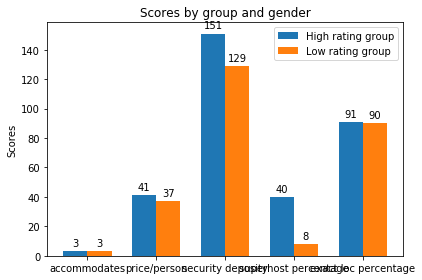

In [256]:
labels = ['accommodates','price/person', 'security deposity', 'superhost percentage', 'exact loc percentage']
y_accommodates = [df3_high_score.accommodates.mean(), df3_low_score.accommodates.mean()]
y_price    = [df3_high_score.price_per_person.mean(), df3_low_score.price_per_person.mean()]
y_deposit = [df3_high_score.security_deposit.mean(), df3_low_score.security_deposit.mean()]
y_superhost = [df3_high_score.host_is_superhost.mean()*100, df3_low_score.host_is_superhost.mean()*100]
y_loc_exact = [df3_high_score.is_location_exact.mean()*100, df3_low_score.is_location_exact.mean()*100]

high_value = [y_accommodates[0], y_price[0], y_deposit[0], y_superhost[0], y_loc_exact[0]]
low_value  = [y_accommodates[1], y_price[1], y_deposit[1], y_superhost[1], y_loc_exact[1]]

high_value_round = [round(h) for h in high_value]
low_value_round  = [round(r) for r in low_value]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, high_value_round, width, label='High rating group')
rects2 = ax.bar(x + width/2, low_value_round, width, label='Low rating group')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [251]:
low_value_round

[3, 37, 129, 8, 90, 79]

In [174]:
df3_low_score.host_is_superhost.mean()

0.02785923753665689

In [187]:
round([1.2, 3.4, 6.7])

TypeError: type list doesn't define __round__ method

In [253]:
x

array([0, 1, 2, 3, 4])

In [255]:
high_value_round

[3, 41, 151, 40, 91, 81]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

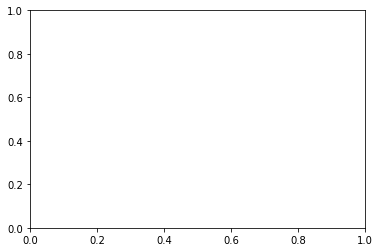

In [254]:
plt.bar(x,high_value_round)